In [1]:
!python mlip_setup_env.py

Initialized empty Git repository in /content/.git/
Updating origin
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 906 (delta 19), reused 19 (delta 7), pack-reused 847
Receiving objects: 100% (906/906), 8.74 MiB | 5.86 MiB/s, done.
Resolving deltas: 100% (526/526), done.
From https://github.com/L-Hess/CS4180-Deep-Learning--CNN
 * [new branch]      master     -> origin/master
Branch 'master' set up to track remote branch 'master' from 'origin'.
Already on 'master'
Changing working directory to code/hw1!
Data not present, retrieving...
  0% 0.00/1.32M [00:00<?, ?B/s]
100% 1.32M/1.32M [00:00<00:00, 44.2MB/s]
  0% 0.00/1.28M [00:00<?, ?B/s]
100% 1.28M/1.28M [00:00<00:00, 42.5MB/s]
  0% 0.00/944 [00:00<?, ?B/s]
100% 944/944 [00:00<00:00, 1.10MB/s]
  0% 0.00/4.72k [00:00<?, ?B/s]
100% 4.72k/4.72k [00:00<00:00, 4.21MB/s]
  0% 0.00/1.70k [00:00<?, ?B/s]
100% 1.70k/1.70k [00:00<00:00, 1.71MB/s]
 

In [1]:
cd code/hw1

/content/code/hw1


In [2]:
%tensorflow_version 2.x

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import categorical_accuracy
import wandb

from flow import evaluate_trained_model, generators_from_prep, preview_from_prep
from helper import generator_wrapper
from starter_eda_model_funcs import MultiOutputDataGenerator
from preprocessing import perform_preprocessing

# further settings
FIG_DIR = 'results/generated_figs/'
plt.rcParams["figure.figsize"] = (10, 4.5) # set higher on 4k monitor
plt.rcParams["savefig.format"] = "pdf"
plt.rcParams["savefig.dpi"] = 400
plt.rcParams["savefig.transparent"] = True
plt.rcParams.update({'font.size': 16})
plt.rcParams["savefig.bbox"] = 'tight'

TensorFlow 2.x selected.


In [3]:
!pip install webdavclient3
!pip install efficientnet

In [0]:
from webdav3.client import Client

options = {
 'webdav_hostname': "https://joeranbosma.stackstorage.com/remote.php/webdav",
 'webdav_login':    ".",
 'webdav_password':  "."
}
client = Client(options)

In [0]:
import efficientnet.tfkeras
import efficientnet.tfkeras as efn
import tensorflow as tf

# Generalized mean pool - GeM
gm_exp = tf.Variable(3.0, dtype = tf.float32)
def generalized_mean_pool_2d(X):
    pool = (tf.reduce_mean(tf.abs(X**(gm_exp)), 
                        axis = [1, 2], 
                        keepdims = False) + 1.e-7)**(1./gm_exp)
    return pool

# Ensemble predictions using models OrigNet and EfficientNetB0

With roi sizes 32, 64 and 96, plus 5 padding each. 

## Fetch and load models

In [6]:
roi_options = [32, 64, 96, 32, 64, 96]
pad_options = [ 5, 5,  5,   5,  5,  5]
model_files_ext = ['models/2020-03-09-Worker-CLR-EfficientNetB0-32/model-best-049.h5', 
                   'models/2020-03-09-Worker-CLR-EfficientNetB0-64/model-best-052.h5', 
                   'models/2020-03-09-Worker-CLR-EfficientNetB0-96/model-best-049.h5', 
                   'models/2020-03-09-Worker-CLR-OrigNet-32/model-best-052.h5', 
                   'models/2020-03-09-Worker-CLR-OrigNet-64/model-best-053.h5', 
                   'models/2020-03-09-Worker-CLR-OrigNet-96/model-best-053.h5']
model_files = [
               'EffNetB0-32-best.h5',
               'EffNetB0-64-best.h5',
               'EffNetB0-96-best.h5',
               'OrigNet-32-best.h5',
               'OrigNet-64-best.h5',
               'OrigNet-96-best.h5',
]
models      = []
download = True # Download only required once

for roi_size, pad_size, ext_model_fn, model_fn in zip(roi_options, pad_options, model_files_ext, model_files):
    if download:
        # API for fetching from stack:
        client.download_sync(remote_path=ext_model_fn, local_path=model_fn)
    models.append(load_model(model_fn))

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=() dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (lambda_1), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=() dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=() dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that thi

In [0]:
# set up
datagen_args = dict(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.15, # Randomly zoom image 
    width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,
    shear_range=8, #Shear Intensity (Shear angle in counter-clockwise direction in degrees)
)

# cross validation settings
cross_val_num = 0; cross_val_parts = 8

# Ensemble prediction with data preprocessing on the fly

In [38]:
from flow import predict_with_prep_on_the_fly
import pickle

ensemble_probs = []
train_or_test='train'

for roi_size, padding, model, model_fn in zip(roi_options, pad_options, models, model_files):
    preprocess_args = dict(
        image_width=roi_size + padding*2,
        image_height=roi_size + padding*2,
        padding=padding,
    )
    
    # folders
    data_path='Data/'
    probs = predict_with_prep_on_the_fly(model, preprocess_args, data_path=data_path,
                                         train_or_test=train_or_test)
    
    
    with open("probs_{}.pickle".format(model_fn), "wb") as handle:
        pickle.dump(probs, handle)
    ensemble_probs.append(probs)

100%|██████████| 4/4 [07:30<00:00, 112.58s/it]


In [0]:
import pickle
ensemble_probs = []
for model_fn in model_files:
    name = f"prep_{roi_size}_{padding}"
    with open("probs_{}.pickle".format(model_fn), "rb") as handle:
        probs = pickle.load(handle)
        ensemble_probs.append(probs)

Have predicted all of the train samples. The models were all trained on cv split 0/8, meaning that the validation samples for that split are unseen by the models. Extract those predictions and tune the model weights.  

From above have:  
`ensemble_probs` which is a list containing `probs` for each model.  
`probs` is a dictionary with:  
- `probs[f"{name}_consonant_diacritic"] = batch_predict[2][idx]`
- `probs[f"{name}_grapheme_root"] = batch_predict[0][idx]`
- `probs[f"{name}_vowel_diacritic"] = batch_predict[1][idx]`

In [51]:
from cross_validation_helper import cv_train_val_split
from helper import to_one_hot

train_or_test = 'train'
data_path = 'Data/'

# read train labels
train_df_ = pd.read_csv('{}/{}.csv'.format(data_path, train_or_test))
# add filename column to train labels df
# train_df_['filename'] = train_df_['image_id'] + '.png'

# convert target labels to one-hot encoding
# this also returns the ordered labels of the newly created columns
# one_hot_columns = ['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']
# train_df_, features = to_one_hot(train_df_, one_hot_columns=one_hot_columns)
# assert len(features) == 168 + 11 + 7, print("found {} one-hot encoded features".format(len(features)))

# split train and validation set
train_df, val_df = cv_train_val_split(train_df_, cross_val_num=cross_val_num,
                                        cross_val_parts=cross_val_parts, random_state=576)
val_df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
32759,Train_32759,72,7,0,দে
137364,Train_137364,79,7,0,ধে
156986,Train_156986,30,7,0,ঘ্নে
38345,Train_38345,69,7,0,ত্বে
83932,Train_83932,149,1,6,স্ট্র্যা


# Combine predictions and find optimal weighted ensemble

In [0]:
from sklearn.metrics import log_loss

class EnsembleClassifier(object):
    def __init__(self, names, root_preds, vowel_preds, cons_preds,
                 root_true=None,  vowel_true=None,  cons_true=None):
        # save names 
        self.names = names
        
        # predictions
        self.root_preds = root_preds
        self.vowel_preds = vowel_preds
        self.cons_preds = cons_preds
        
        # true labels (only required for calculating accuracy and loss)
        self.root_true = root_true
        self.vowel_true = vowel_true
        self.cons_true = cons_true
        
    def multiply(self, w, y):
        sh = y.shape
        # multiply y with w, along the first axis
        return (w @ y.reshape(sh[0], sh[1]*sh[2])).reshape(sh[1], sh[2])

    def weighed_pred(self, w):
        """Soft voting with weighed averaging of predicted probabilities"""
        w = np.array(w)
        
        y_root = self.multiply(w, self.root_preds) / np.sum(w)
        y_vowel = self.multiply(w, self.vowel_preds) / np.sum(w)
        y_cons = self.multiply(w, self.cons_preds) / np.sum(w)
        return y_root, y_vowel, y_cons
    
    def weighed_class(self, w):
        y_root, y_vowel, y_cons = self.weighed_pred(w)
        y_root = np.argmax(y_root, axis=-1)
        y_vowel = np.argmax(y_vowel, axis=-1)
        y_cons = np.argmax(y_cons, axis=-1)
        return y_root, y_vowel, y_cons
    
    def calc_acc(self, w):
        y_root, y_vowel, y_cons = self.weighed_class(w)
        acc_root = np.mean( y_root == self.root_true )
        acc_vowel = np.mean( y_vowel == self.vowel_true )
        acc_cons = np.mean( y_cons == self.cons_true )
        acc_glob = 0.5 * acc_root + 0.25 * (acc_vowel + acc_cons)
        return acc_root, acc_vowel, acc_cons, acc_glob
    
    def calc_loss(self, w):
        y_root, y_vowel, y_cons = self.weighed_pred(w)
        # loss = binary crossentropy, per class
        loss_root = log_loss( self.root_true, y_root )
        loss_vowel = log_loss( self.vowel_true, y_vowel )
        loss_cons = log_loss( self.cons_true, y_cons )
        # exp(-2)/exp(-1)
        loss = 0.4 * loss_root + 0.3 * (loss_vowel + loss_cons)
        # loss = 0.3678794412 * loss_root + 0.25 * (loss_vowel + loss_cons)
        return loss

In [0]:
names = []
for roi_size in roi_options[0:3]:
    names.append( "EffNetB0-{}".format(roi_size) )
for roi_size in roi_options[3:6]:
    names.append( "OrigNet-{}".format(roi_size) )
    
# convert ensemble_probs to three lists of probs
root_preds = np.zeros(shape=( len(ensemble_probs), val_df.index.size, 168 ))
vowel_preds = np.zeros(shape=( len(ensemble_probs), val_df.index.size, 11 ))
cons_preds = np.zeros(shape=( len(ensemble_probs), val_df.index.size, 7 ))

for i, (idx, row) in enumerate(val_df.iterrows()):
    name = row['image_id']
    
    for j in range(len(ensemble_probs)):
        root_preds[j, i] = ensemble_probs[j][name+'_grapheme_root']
        vowel_preds[j, i] = ensemble_probs[j][name+'_vowel_diacritic']
        cons_preds[j, i] = ensemble_probs[j][name+'_consonant_diacritic']

In [0]:
model = EnsembleClassifier(names, root_preds, vowel_preds, cons_preds,
                          root_true=val_df['grapheme_root'].values,
                          vowel_true=val_df['vowel_diacritic'].values,
                          cons_true=val_df['consonant_diacritic'].values,)

In [0]:
def plot_accuracy_gain(acc, labels, baseline, fn):
    f, axes = plt.subplots(1, 1, figsize=(10, 5))
    ax = axes

    # calculate means and std. between trails
    if len(acc.shape) >= 2:
        try:
            means, stds = np.mean(acc, axis=-1), np.std(acc, axis=-1)
        except:
            assert isinstance(acc, list), "Need ndarray or list"
            means, stds = [], []
            for acc_row in acc:
                means.append(np.mean(acc_row))
                stds.append(np.std(acc_row))
            means, stds = np.array(means), np.array(stds)
    else:
        means = acc
        stds = np.zeros_like(acc)

    # plot bar plot with height the mean and error bars the deviation
    # substract a baseline from all means
    y = means - means[baseline]
    ax.bar(range(len(labels)), height=y, yerr=stds, capsize=4)
    ax.axhline(0, color='k')
    ax.set_xticklabels(labels, rotation=40)
    ax.set_xticks(range(len(labels)))

    # write total accuracy above bars
    for i, (v, a) in enumerate(zip(y, means)):
        ax.text(i, v, f"{a:,.2%}", va='bottom', ha='center', fontweight='bold')

    # Set yticks to percentage
    vals = ax.get_yticks()
    # calculate the number of decimals to show without losing information
    num_decimals = max(0, int(np.ceil(np.mean(np.abs(np.log10(np.diff(vals)))) - 2)))
    labels = ['{x:,.{num}%}'.format(x=x, num=num_decimals) for x in vals]
    ax.set_yticklabels(labels)
    ax.set_ylabel("Validation accuracy gain")

    # Hide the right and top spines
    for loc in ['right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)

    f.tight_layout()
    f.savefig('{fn}'.format(fn=fn))
    plt.show()

In [0]:
accuracies = []
for i in range(6):
    w = np.zeros(6)
    w[i] = 1
    acc = model.calc_acc(w=w) # individual score
    accuracies.append(acc)

acc = model.calc_acc(w=np.ones(6)) # equal weight ensemble
accuracies.append(acc)
acc = model.calc_acc(w=[0.12637356, 0.35241412, 0.70373072, 0.8849216, 1.67389513, 2.25107345]) # from minimizing loss
accuracies.append(acc)

In [88]:
accuracies = np.array(accuracies)
accuracies

array([[0.91639116, 0.97761402, 0.97749452, 0.94697271],
       [0.95008962, 0.9852619 , 0.98621788, 0.96791476],
       [0.95626369, 0.98621788, 0.98637722, 0.97128062],
       [0.9539534 , 0.98669588, 0.98585939, 0.97011551],
       [0.96108345, 0.98884684, 0.9891655 , 0.97504481],
       [0.9639514 , 0.98968333, 0.98912567, 0.97667795],
       [0.96554471, 0.99028082, 0.98980283, 0.97779327],
       [0.96689902, 0.99079865, 0.99004182, 0.97865963]])

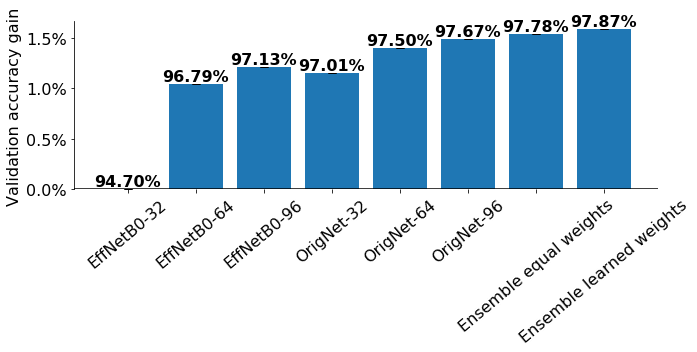

In [91]:
labels = names.copy()
labels.append("Ensemble equal weights")
labels.append("Ensemble learned weights")
plot_accuracy_gain(accuracies[:,3], labels, baseline=0, fn='v2-ensemble-learned')

In [0]:
# acc = model.calc_acc(w=[1, 1, 1, 0, 0, 0]) # EffNet ensemble
# accuracies.append(acc)
# acc = model.calc_acc(w=[0, 0, 0, 1, 1, 1]) # OrigNet ensemble
# accuracies.append(acc)

0.07325927870061064

### Find optimal weight between models

#### By minimizing the loss

In [82]:
from scipy.optimize import minimize

def ensemble_loss(w, model):
    loss = model.calc_loss(w)
    return loss

w = np.ones(shape=len(model.root_preds))
res = minimize(ensemble_loss, w, args=(model),
               options={'disp': True})

Optimization terminated successfully.
         Current function value: 0.073287
         Iterations: 45
         Function evaluations: 432
         Gradient evaluations: 54


In [83]:
w = res.x
print(w)

[0.12637356 0.35241412 0.70373072 0.8849216  1.67389513 2.25107345]


In [84]:
model.calc_acc(w=w) # all models with optimal weight

(0.9668990240987851,
 0.9907986456881099,
 0.9900418243377813,
 0.9786596295558654)

Above yielded weights [0.12702652 0.35039732 0.71088811 0.88812854 1.66365081 2.25348977] with loss weights exp(-1), 0.25 and 0.25, giving accuracies (0.966938856801434, 0.9907986456881099, 0.9900418243377813, 0.9786795459071898) (root, vowel, cons, global)

In [70]:
def ensemble_acc_inv(w, model):
    acc_root, acc_vowel, acc_cons, acc_glob = model.calc_acc(w)
    return -acc_glob # for minimize function

w = np.ones(6)
res = minimize(ensemble_acc_inv, w, args=(model), method='nelder-mead', 
               options={'xatol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: -0.978371
         Iterations: 65
         Function evaluations: 245


In [71]:
res.x

array([0.71996275, 0.60739458, 1.14379209, 1.15353051, 1.19734363,
       1.23730094])

### Line search to find best validation accuracy
Should at least be able to not decrease the validation accuracy of 97.754% of w=[1, 1, 1, 1].

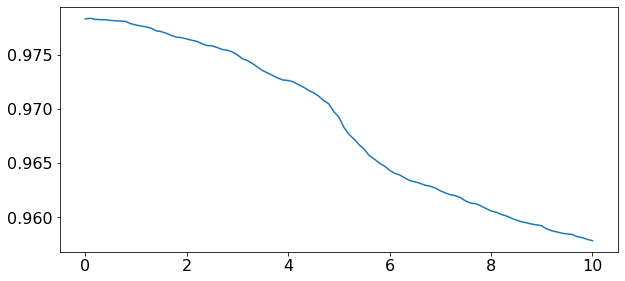

Updating w[0]: 1.0 ==> 0.1 (97.841%)


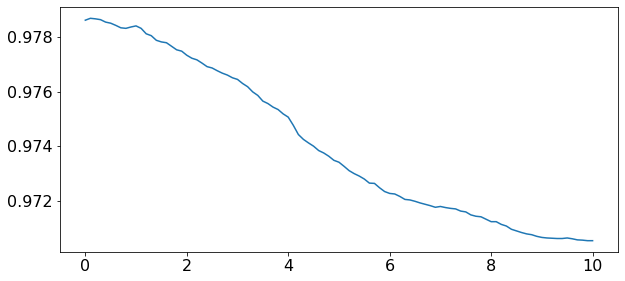

Updating w[1]: 1.0 ==> 0.1 (97.869%)


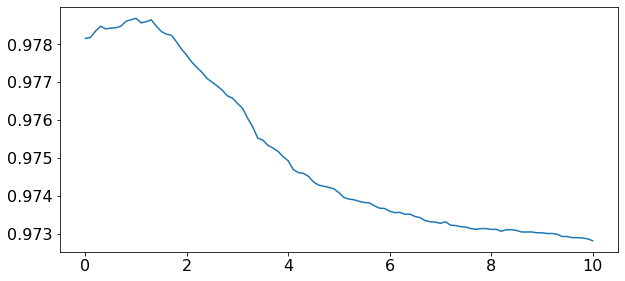

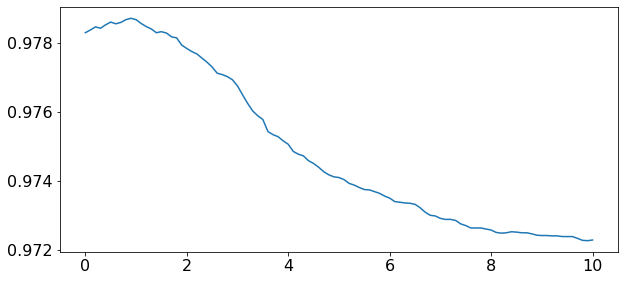

Updating w[3]: 1.0 ==> 0.9 (97.873%)


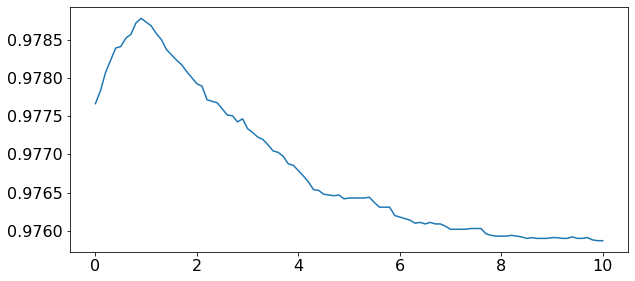

Updating w[4]: 1.0 ==> 0.9 (97.878%)


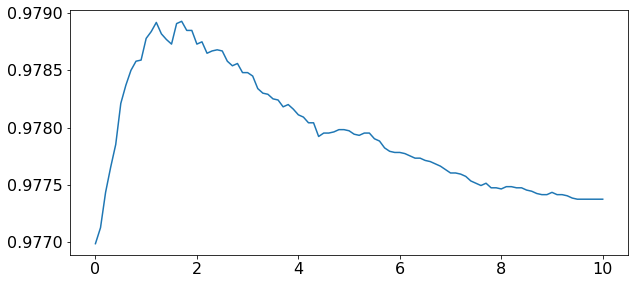

Updating w[5]: 1.0 ==> 1.7000000000000002 (97.893%)


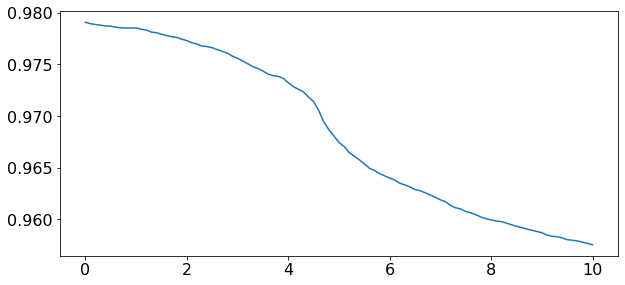

Updating w[0]: 0.1 ==> 0.0 (97.907%)


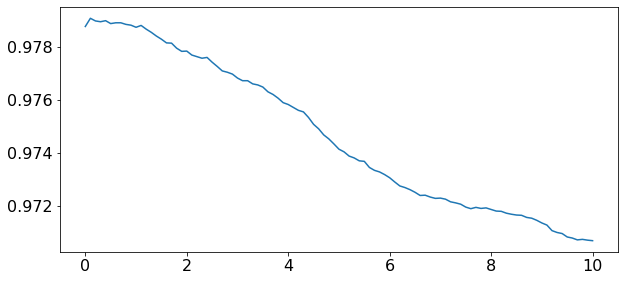

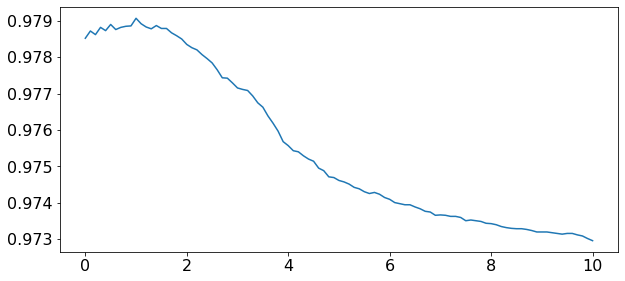

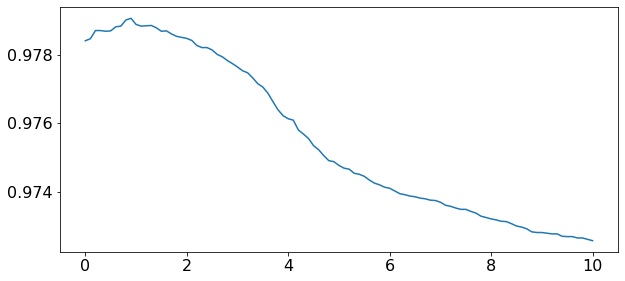

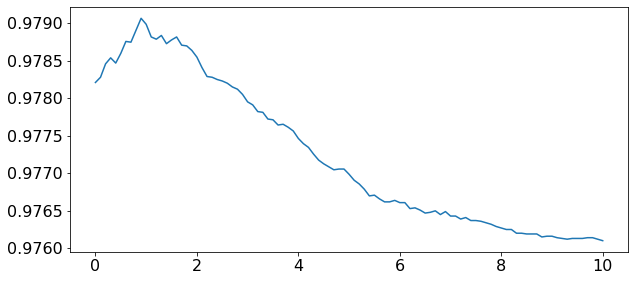

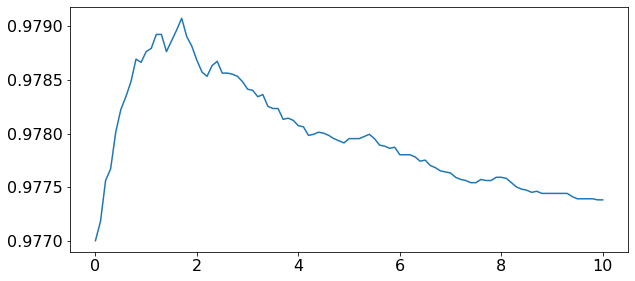

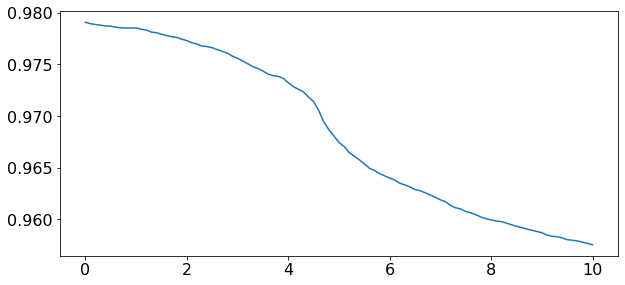

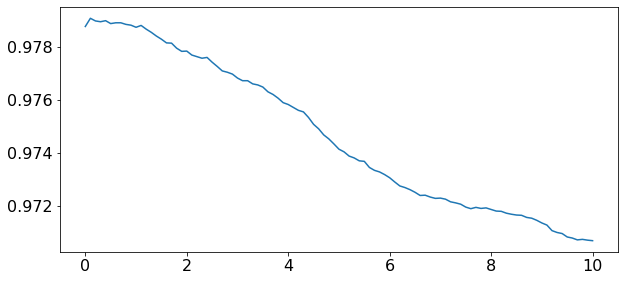

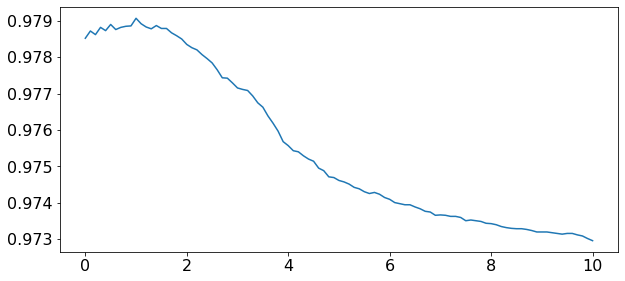

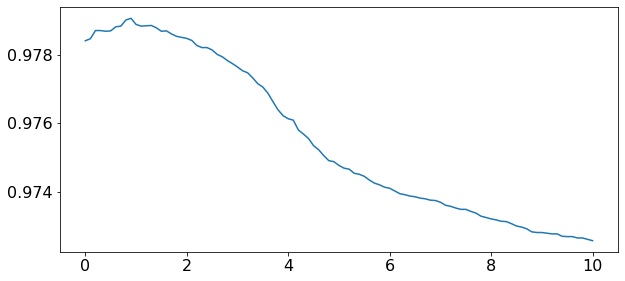

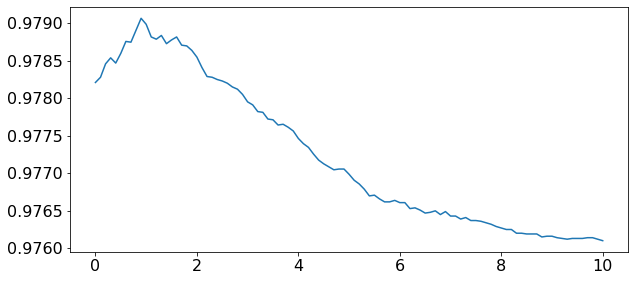

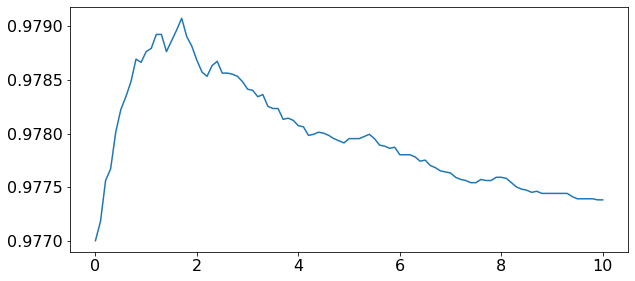

In [73]:
w = np.ones(6)

for it in range(10):
    converged = True
    
    for i in range(6):
        accs = []
        xrange = np.linspace(0, 10, num=101)
        for wi in xrange:
            wnew = w.copy()
            wnew[i] = wi

            accs.append( model.calc_acc(wnew)[3] )
        plt.plot(xrange, accs)
        plt.show()

        w_best = xrange[np.argmax(accs)]
        if w[i] != w_best:
            print("Updating w[{}]: {} ==> {} ({:,.3%})".format(i, w[i], w_best, np.max(accs)))
            w[i] = w_best
            converged = False
    
    if converged:
        break

In [74]:
print(w); print(model.calc_acc(w))

[0.  0.1 1.  0.9 0.9 1.7]
(0.9676160127464648, 0.9907189802828121, 0.9903206532563235, 0.9790679147580164)
